<a href="https://colab.research.google.com/github/geeky-programer/Covid/blob/master/SIR_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python --version

Python 3.7.13


In [3]:
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lisphilar/covid19-sir.git to /tmp/pip-install-v7zzecjo/covsirphy_87e526b543c547e0968f5d3903a4703d
  Running command git clone -q https://github.com/lisphilar/covid19-sir.git /tmp/pip-install-v7zzecjo/covsirphy_87e526b543c547e0968f5d3903a4703d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 2.1 MB/s 
     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 308 kB 49.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 1.0 MB 51.7 MB/s 
     |████████████████████████████████| 486 kB 58.9 MB/s 
     |████████████████████████████████| 167 kB 57.6 MB/s 
     |████████████████████████████████| 991 kB 48.5 MB/s 
     |████████████████████████████████| 235 

In [4]:
import covsirphy as cs
cs.__version__

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.24.0-mu-1'

In [5]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
#import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [7]:
!pip install dask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#import dask.dataframe as dd

In [9]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [10]:
data_loader = cs.DataLoader(directory="kaggle/input")
jhu_data = data_loader.jhu()

Retrieving COVID-19 dataset from https://github.com/lisphilar/covid19-sir/data/
Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving datasets from Our World In Data https://github.com/owid/covid-19-data/
Retrieving datasets from COVID-19 Open Data by Google Cloud Platform https://github.com/GoogleCloudPlatform/covid-19-open-data


In [11]:
jhu_data.cleaned().tail()

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
948177,2022-06-21,ZWE,Zimbabwe,-,254919,166389,5536,82994,14439018
948178,2022-06-22,ZWE,Zimbabwe,-,255049,166514,5541,82994,14439018
948179,2022-06-23,ZWE,Zimbabwe,-,255136,166600,5542,82994,14439018
948180,2022-06-24,ZWE,Zimbabwe,-,255309,166766,5549,82994,14439018
948181,2022-06-25,ZWE,Zimbabwe,-,255309,166766,5549,82994,14439018


In [12]:
jhu_data.subset("Japan", province=None).tail()

,Date,Confirmed,Infected,Fatal,Recovered,Susceptible
864,2022-06-22,9193361,158352,31077,9003932,117335739
865,2022-06-23,9210035,158570,31092,9020373,117319065
866,2022-06-24,9226006,161297,31107,9033602,117303094
867,2022-06-25,9242596,161838,31116,9049642,117286504
868,2022-06-26,9256834,162532,31128,9063174,117272266


In [13]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

908 days have passed from the date of the first record.


In [14]:
pyramid_data = data_loader.pyramid()

In [15]:
# marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


In [16]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Germany")

Retrieving population pyramid dataset (Germany) from https://data.worldbank.org/


,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,2417094,0.031933
1,3,5,nursery school,4,0,1,5,2370155,0.031313
2,6,10,elementary school,5,0,1,10,3791695,0.050093
3,11,13,middle school,5,0,1,13,2269977,0.029989
4,14,18,high school,6,0,1,18,4027327,0.053206
5,19,25,university/work,3,3,1,25,6294846,0.083162
6,26,35,work,0,6,1,35,10309780,0.136204
7,36,45,work,0,5,1,45,10362882,0.136906
8,46,55,work,0,5,1,55,12098943,0.159841
9,56,65,work,0,5,1,65,12140164,0.160386


In [17]:
"""ita_action_raw = pd.read_excel(
    "/kaggle/input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()
"""

'ita_action_raw = pd.read_excel(\n    "/kaggle/input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",\n    sheet_name="Foglio1"\n)\nita_action_raw.head()\n'

In [18]:
"""df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()
"""

'df = ita_action_raw.copy()\ndf = df.drop(["Country", "Village", "link"], axis=1)\ndf.columns = [col.capitalize().replace(" ", "_") for col in df.columns]\ndf["Start_date"] = pd.to_datetime(df["Start_date"])\ndf["End_date"] = pd.to_datetime(df["End_date"])\ndf["Region"] = df["Region"].fillna("-")\ndf["Number_of_people"] = df["Number_of_people"].fillna(-1)\nita_action_df = df.copy()\nita_action_df.tail()\n'

In [19]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [20]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2022-06-23,494907733,303951571,5685236,185270926,0.011487,0.374354,0.029772
2022-06-24,491449131,300510719,5655114,185283298,0.011507,0.377014,0.029617
2022-06-25,482685094,291707888,5630076,185347130,0.011664,0.383992,0.029480
2022-06-26,118458675,23432466,1198525,93827684,0.010118,0.792071,0.012613
2022-06-27,3612535,3593458,6120,12957,0.001694,0.003587,0.320805


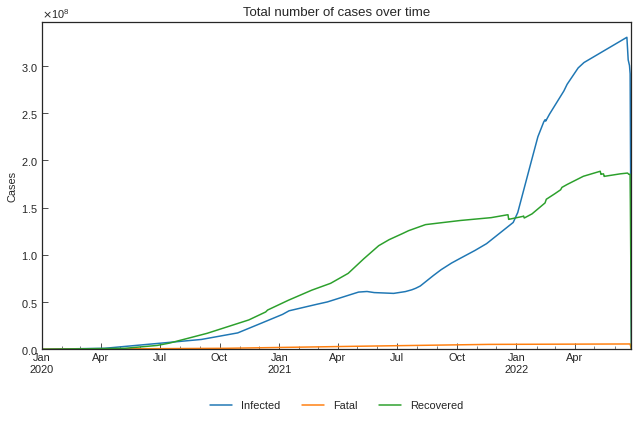

In [21]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

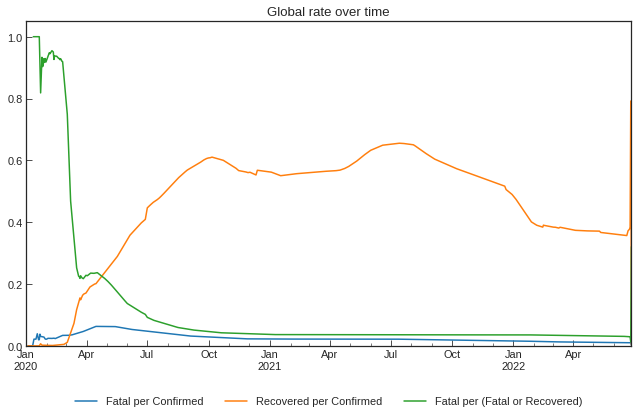

In [22]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

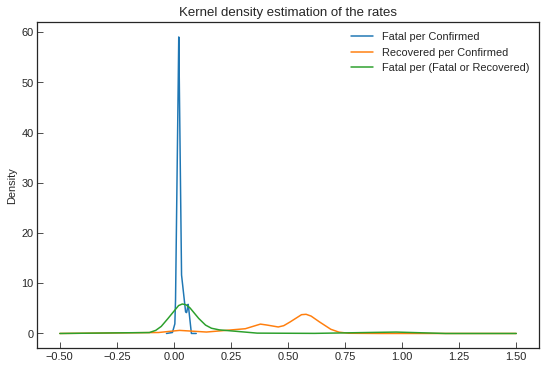

In [23]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [24]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,907.0,0.025649,0.013314,0.0,0.020057,0.021584,0.029169,0.065202
Recovered per Confirmed,907.0,0.457443,0.179693,0.0,0.372103,0.545133,0.576905,1.000000
Fatal per (Fatal or Recovered),899.0,0.112740,0.213958,0.0,0.033026,0.036672,0.056778,1.000000


In [25]:
#calculating growth factor

covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country,-,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, British","Virgin Islands, U.S.",Wallis and Futuna,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-09,1.0,0.79,1.35,1.02,0.86,0.71,1.0,0.86,0.71,0.86,...,1.09,0.49,0.80,0.90,1.00,1.24,1.0,1.00,0.74,0.80
2022-06-10,1.0,0.70,1.33,1.09,0.86,0.71,1.0,0.86,1.09,0.86,...,1.02,0.48,0.73,1.00,0.86,1.20,1.0,1.00,0.76,0.79
2022-06-18,1.0,1.15,0.54,1.50,1.00,0.86,1.0,0.86,1.09,0.86,...,1.45,0.89,1.00,1.02,0.86,0.71,1.0,0.86,1.30,0.79
2022-06-19,1.0,1.34,0.57,1.55,1.00,0.86,1.0,0.86,0.94,0.86,...,1.45,10.32,0.98,1.08,0.86,0.71,1.0,0.86,1.30,0.79
2022-06-20,1.0,1.29,0.59,1.19,1.00,0.86,1.0,0.86,0.66,0.71,...,1.45,10.22,1.06,1.06,0.86,0.71,1.0,0.86,1.19,0.76


SIR non dimensional implementation

In [26]:
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")

example_data.cleaned()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Please use Dynamics.from_sample() rather than ExampleData(), version >= 2.24.0-kappa.
  """Entry point for launching an IPython kernel.


,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


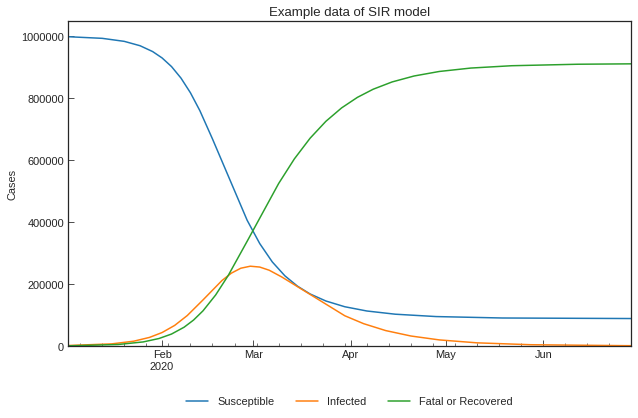

In [28]:
model = cs.SIR
area = {"country": "Germany", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

In [29]:
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


In [30]:
df = example_data.specialized(model, **area)
df.head()

,Date,Susceptible,Infected,Fatal or Recovered
0,2020-01-02,998787,1133,80
1,2020-01-03,998547,1283,170
2,2020-01-04,998273,1454,273
3,2020-01-05,997964,1647,389
4,2020-01-06,997614,1865,521


In [31]:
# Calculate reproduction number
# Note: population value will be applied, but not used in calculation
param_dict = cs.SIR.EXAMPLE["param_dict"].copy()
model_instance = cs.SIR(population=100000, **param_dict)
r0 = model_instance.calc_r0()
print(f"Reproduction number of {model_instance.NAME} model: {r0}")

Reproduction number of SIR model: 2.67


In [32]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)


(0.366211, 0.37453183520599254)

Hyperparameter optimization
In the previous paragraphs figures, we calculated the number of cases based on hypothesized parameter values. However, we do not know parameter values of the actual data. Here, we will estimate the ( 𝜃,𝜅,𝜌,𝜎 ) values of the example data using hyperparameter optimization method by Optuna package.  𝜏  will be fixed as 1440 [min].

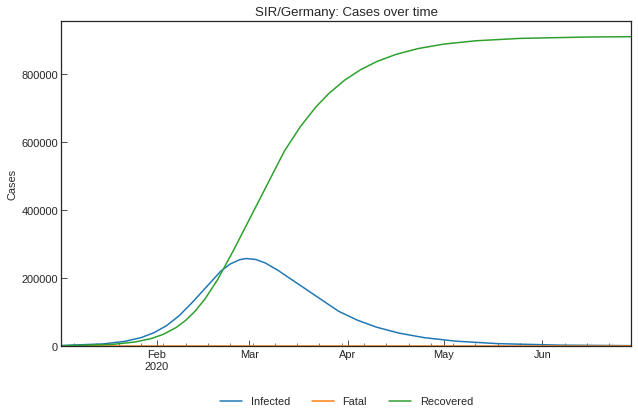

In [33]:
sirf_snl = cs.Scenario(example_data, tau=1440, **area)
_ = sirf_snl.records()

In [34]:
# Set phases (phase: explained in "S-R trend analysis section")
# Records at 01Jan2020 will be removed because Recovered = 0
sirf_snl.clear(include_past=True)
sirf_snl.add().summary()

,Type,Start,End,Population
0th,Past,02Jan2020,29Jun2020,1000000


In [35]:
# Parameter estimation
sirf_snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 2 CPUs...


[I 2022-06-27 08:54:15,083] A new study created in memory with name: no-name-581dc54a-ee62-42f5-bfdf-72fefb4761fa
[I 2022-06-27 08:54:15,111] Trial 0 finished with value: 6.416699292360972 and parameters: {'theta': 0.2744067519636624, 'kappa': 0.0, 'rho': 0.20232757150755995, 'sigma': 0.07468937098184168}. Best is trial 0 with value: 6.416699292360972.
[I 2022-06-27 08:54:15,128] Trial 1 finished with value: 6.381781245773957 and parameters: {'theta': 0.27244159149844843, 'kappa': 0.0, 'rho': 0.19671026363805105, 'sigma': 0.07497651018126214}. Best is trial 1 with value: 6.381781245773957.
[I 2022-06-27 08:54:15,147] Trial 2 finished with value: 6.3499117013048245 and parameters: {'theta': 0.21879360563134626, 'kappa': 0.0, 'rho': 0.20572999698762945, 'sigma': 0.07709202782325794}. Best is trial 2 with value: 6.3499117013048245.
[I 2022-06-27 08:54:15,165] Trial 3 finished with value: 6.315282305618968 and parameters: {'theta': 0.19172075941288885, 'kappa': 0.0, 'rho': 0.20380226603648

	02Jan2020 - 29Jun2020: finished  575 trials in 0 min 16 sec
Completed optimization. Total: 0 min 16 sec


Note:
"Score" is Root Mean Squared Log Error (RMSLE) score.
1𝑛∑𝑖=1𝑛(𝑙𝑜𝑔10(𝐴𝑖+1)−𝑙𝑜𝑔10(𝑃𝑖+1))2‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
 
Where  𝐴  is observed (actual) values,  𝑃  is estimated (predicted) values. Variables are  𝑆  ( 𝑖=1 ),  𝐼  ( 𝑖=2 ),  𝑅  ( 𝑖=3 ) and  𝐹  ( 𝑖=𝑛=4 ) for SIR-F model. When RMSLE score is low, hyperparameter estimation is highly accurate.
Please refer to What’s the Difference Between RMSE and RMSLE?


In [36]:
df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"], **cs.SIRF.EXAMPLE["param_dict"])
setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE": cs.SIRF.NAME,
    "Rt": setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}
df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,RMSLE,Trials,Runtime,1/alpha2 [day],1/beta [day],1/gamma [day],alpha1 [-]
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.65,0.000001,0.000,0.200844,0.0758,1440,0.344245,575.0,0 min 16 sec,-,-,-,-
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005,0.200000,0.0750,1440,-,-,-,200.0,5.0,13.0,0.002


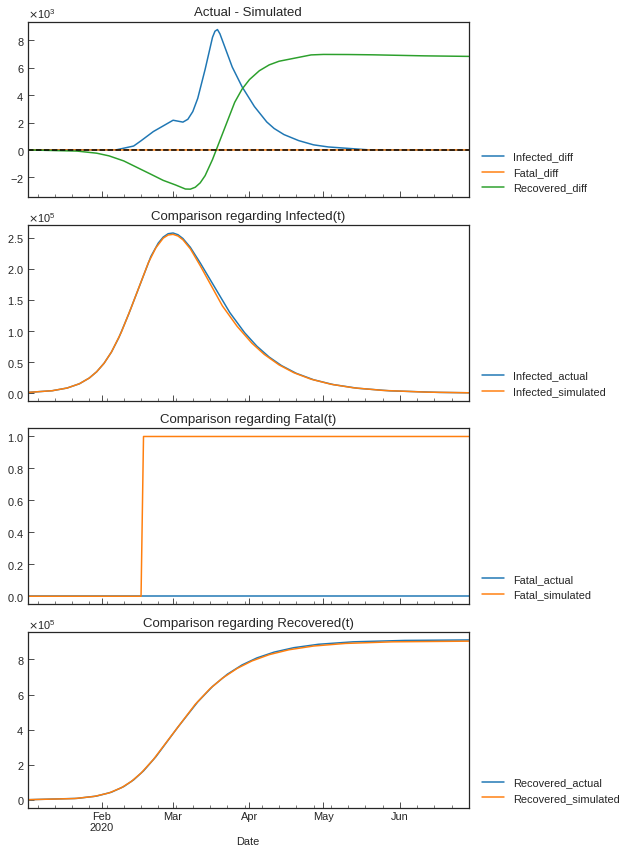

In [37]:
sirf_snl.estimate_accuracy("0th")